In [61]:
#引用以下包做数据处理
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from common import preprocess
#引用以下包做数据可视化
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from warnings import filterwarnings
pd.set_option('display.float_format',lambda x : '%.4f' % x)

In [62]:
df = pd.read_csv("/data/paper/sample/s-0-1-0.csv",index_col=0)
#df = preprocess(df)
df = df.head(10000)
df

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,service_gssapi,service_http,service_irc,service_smb,service_smb;gssapi,service_ssh,service_ssl,proto_icmp,proto_tcp,proto_udp
244353,42100,7878,tcp,-,0.0000,0,0,OTH,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
271526,60237,15600,udp,-,0.0000,0,0,S0,0,1,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
212100,34407,15600,udp,-,0.0000,0,0,S0,0,1,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
449950,5353,5353,udp,dns,13.0451,448,0,S0,0,4,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
316521,50948,9000,tcp,-,0.0000,0,0,S0,0,1,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423812,53972,10502,tcp,-,0.0000,0,0,OTH,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
163953,47664,53,udp,dns,0.1605,44,228,SF,0,1,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
62408,53972,10502,tcp,-,0.0000,0,0,OTH,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
438182,51427,5355,udp,dns,0.0000,66,0,S0,0,2,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


<AxesSubplot:xlabel='Source', ylabel='duration'>

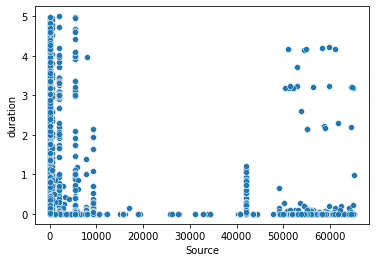

In [63]:
df1=pd.DataFrame()
df1['Source']=df['dst_port']
df1['Y']=df['dst_bytes']
df1['duration'] = df['duration'] % 5
sns.scatterplot(x=df1['Source'],y='duration',data=df1)

In [441]:
df = pd.read_csv("/data/paper/sample/s-3-4-3.csv",index_col=0)
df = preprocess(df)

In [442]:
df[df['label']==1].shape[0]

167050

In [443]:
df[df['label']==0].shape[0]

332950

In [444]:
(df[df['label']==0].shape[0])/(df[df['label']==1].shape[0])

1.9931158335827597

In [432]:
df.shape[0]

50000